In [ ]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_loading import EmotionDatasetPreparer
from preprocessing import AudioFeatureExtractor  

from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, Concatenate, Flatten)

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [ ]:
datasets = {
    "RAVDESS": "data/RAVDESS/",
    "CREMA-D": "data/AudioWAV",
    "TESS": "data/TESS/",
    "EmoDB": "data/EmoDB/",
    "IESC": "data/IESC/"
}

preparer = EmotionDatasetPreparer(datasets)
dfs = preparer.generate_csvs()
df = preparer.merge_and_clean(dfs)

print("Loaded dataset shape:", df.shape)
print(df.head())

# Feature Extraction

In [ ]:
extractor = AudioFeatureExtractor(
    sample_rate=16000,
    n_mels=128,
    n_mfcc=40,
    max_len=200
)

X_spec, X_prosodic, y = extractor.process_dataframe(df)

print("Spectrogram features shape:", X_spec.shape)
print("Prosodic features shape:", X_prosodic.shape)
print("Labels shape:", y.shape)

In [3]:
# Normalize prosodic features
scaler = StandardScaler()
X_prosodic = scaler.fit_transform(X_prosodic)

# Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(le.classes_))

# Train-Val-Test Split

In [4]:
X_spec_train, X_spec_temp, X_pros_train, X_pros_temp, y_train, y_temp, y_cat_train, y_cat_temp = train_test_split(
    X_spec, X_prosodic, y_encoded, y_cat, test_size=0.3, random_state=42, stratify=y_encoded
)
X_spec_val, X_spec_test, X_pros_val, X_pros_test, y_val, y_test, y_cat_val, y_cat_test = train_test_split(
    X_spec_temp, X_pros_temp, y_temp, y_cat_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Spectrogram Input:", X_spec_train.shape, "Prosodic Input:", X_pros_train.shape)

Spectrogram Input: (10931, 128, 200, 2) Prosodic Input: (10931, 7)


# Model Architecture

In [5]:
input_spec = Input(shape=X_spec_train.shape[1:], dtype='float32')
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_spec)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling2D()(x)

# Prosodic branch (unchanged)
input_pros = Input(shape=(X_pros_train.shape[1],), dtype='float32')
y = Dense(64, activation='relu')(input_pros)
y = Dense(32, activation='relu')(y)
y = Dropout(0.2)(y)

# Fusion
fusion = Concatenate()([x, y])
fusion = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(fusion)
fusion = Dropout(0.3)(fusion)
output = Dense(len(le.classes_), activation='softmax')(fusion)

model = Model(inputs=[input_spec, input_pros], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 200,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 200,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 200,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 100,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 100,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 100,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 100,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 50,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 50,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 50,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 25,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 25,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 25,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 12,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 12,     │          0 │ max_pooling2d_3[

 Total params: 1,021,639 (3.90 MB)

 Trainable params: 1,020,167 (3.89 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Training

In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ModelCheckpoint("best_fusion_modelv1.keras", monitor="val_accuracy", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

history = model.fit(
    [X_spec_train, X_pros_train], y_cat_train,
    validation_data=([X_spec_val, X_pros_val], y_cat_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 644s 923ms/step - accuracy: 0.4692 - loss: 1.3347 - val_accuracy: 0.3128 - val_loss: 1.9367 - learning_rate: 0.0010
Epoch 2/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 715s 971ms/step - accuracy: 0.6054 - loss: 0.9773 - val_accuracy: 0.6133 - val_loss: 0.9755 - learning_rate: 0.0010
Epoch 3/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 684s 973ms/step - accuracy: 0.6431 - loss: 0.8900 - val_accuracy: 0.5958 - val_loss: 1.0136 - learning_rate: 0.0010
Epoch 4/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 657s 960ms/step - accuracy: 0.6663 - loss: 0.8325 - val_accuracy: 0.6129 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 5/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 642s 938ms/step - accuracy: 0.6783 - loss: 0.7941 - val_accuracy: 0.6581 - val_loss: 0.8868 - learning_rate: 0.0010
Epoch 6/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 657s 960ms/step - accuracy: 0.6950 - loss: 0.7691 - val_accuracy: 0.6799 - val_loss: 0.8506 - learning_rate: 0.0010
Epoch 7/50
684/684 ━━━━━━━━━━━━━━━━━━━━ 637s 931ms/step - accura

# Evaluation

In [7]:
test_loss, test_acc = model.evaluate([X_spec_test, X_pros_test], y_cat_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.8088 - loss: 0.6195
Test Accuracy: 80.88%


In [8]:
y_pred_probs = model.predict([X_spec_test, X_pros_test])
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.86      0.87      0.87       377
     disgust       0.79      0.81      0.80       346
        fear       0.76      0.76      0.76       368
       happy       0.80      0.72      0.76       368
     neutral       0.85      0.84      0.85       369
         sad       0.73      0.78      0.76       366
   surprised       0.97      0.97      0.97       149

    accuracy                           0.81      2343
   macro avg       0.82      0.82      0.82      2343
weighted avg       0.81      0.81      0.81      2343



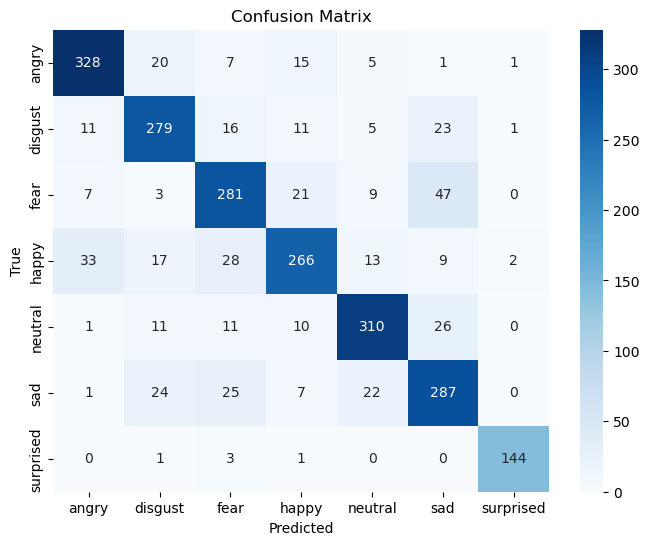

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
try:
    auc = roc_auc_score(y_cat_test, y_pred_probs, average="macro", multi_class="ovr")
    print(f"Macro ROC-AUC: {auc:.4f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

Macro ROC-AUC: 0.9719


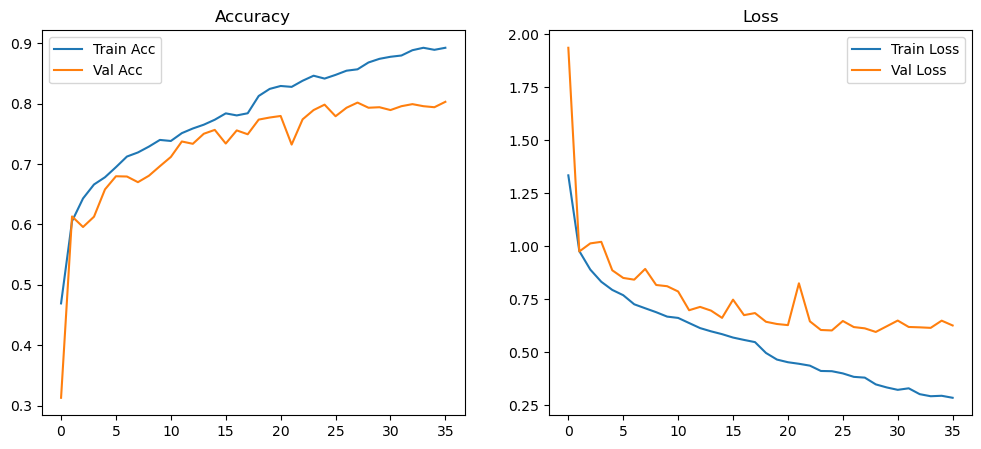

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()